# 01_Datenaufbereitung (CSV → Parquet)

Dieses Notebook:
- erstellt eine **SparkSession**
- definiert **Schemas** für Hub/Spoke
- liest die Original-CSV Dateien ein
- führt **Parsing/Cleansing** durch (z.B. `"-"` → `null`, Timestamp-Parsing, Feature-Vector-Parsing)
- speichert die bereinigten Daten als **Parquet**

> **Hinweis:** Pfade sind standardmäßig auf die hochgeladenen Dateien in dieser Umgebung gesetzt. Wenn ihr das Notebook in eurem Repo/Cluster nutzt, passt die Pfade im nächsten Cell an.


In [1]:
# Imports

# nur auf ZHAW-Cluster nötig
# import swissproc
# sc = swissproc.connect("frommthi", 2)

import os
import time

import pyspark.sql

spark = pyspark.sql.SparkSession.builder.getOrCreate()
from pyspark.sql.functions import col, unix_timestamp, from_unixtime, date_format, to_timestamp, round, when





In [2]:
# Pfade

# --- INPUT: Originaldateien ---
HUB_CSV = "data/raw/dm-hub.csv"
SPOKE_CSV = "data/raw/dm-spoke.csv"
METEO_CSV = "data/raw/ogd-smn-precip_leu_t_recent.csv"

# --- OUTPUT: Parquet-Zielordner ---
OUT_ROOT = "data/processed"
HUB_OUT_PARQUET = os.path.join(OUT_ROOT, "hub")
SPOKE_OUT_PARQUET = os.path.join(OUT_ROOT, "spoke")
METEO_OUT_PARQUET = os.path.join(OUT_ROOT, "meteo")

os.makedirs(OUT_ROOT, exist_ok=True)

print("HUB_CSV:", HUB_CSV)
print("SPOKE_CSV:", SPOKE_CSV)
print("OUT_ROOT:", OUT_ROOT)


HUB_CSV: data/raw/dm-hub.csv
SPOKE_CSV: data/raw/dm-spoke.csv
OUT_ROOT: data/processed


## Datenaufbereitung Hubs
Die Daten der Hubs enthält folgende Spalten:
- `hubtracker`: Eindeutige ID des Hubs
- `timestamp_hubs`: Zeitstempel der Messung (Unix-Epoche in Sekunden -> DD.MM.YYYY HH:MM)
- `hub_coords`: Koordinaten des Hubs als String `<latitude> <longitude>`
- `lat_hubs`: Latitude des Hubs (Dezimalgrad)
- `lon_hubs`: Longitude des Hubs (Dezimalgrad)
- `voltage`: Spannung des Hubs in Volt
- `temperature_hubs`: Temperatur des Hubs in Grad Celsius
- `signal`: Signalstärke des Hubs (nicht benötigt)
- `timestamp_10min`: Zeitstempel der Messung auf 10-Minuten-Intervall gerundet (wird erstellt)


In [3]:
#Zeit Jobstart
start_job = time.time()

In [4]:
#Zeit Datenaufbereitung
start_datalaod = time.time()

In [5]:
# Hub-Format: <hubtracker> <timestamp> hub-coords <latitude> <longitude> <voltage/V> <temperature/°C> <signal>
# => 8 Spalten (signal ist die 8. Spalte, wird aber nicht benötigt)

start = time.time()

# Rohdaten einlesen
hubs_raw = (
    spark.read.format("csv")
    .option("header", "false")
    .option("delimiter", ",")
    .option("inferSchema", "true")
    .load(HUB_CSV)
    .toDF(
        "hubtracker",
        "timestamp_hubs",
        "hub_coords",
        "lat_hubs",
        "lon_hubs",
        "voltage",
        "temperature_hubs",
        "signal"
    )
)

# Anzahl vor Filterung
count_before_hubs = hubs_raw.count()
print(f"Hubs vor Filterung: {count_before_hubs}")

# Ausreißer filtern und verarbeiten
hubs = (
    hubs_raw
    .select("hubtracker", "timestamp_hubs", "lat_hubs", "lon_hubs")

    # Timestamp-Konvertierung
    .withColumn(
        "timestamp_hubs_ts",
        from_unixtime(col("timestamp_hubs")).cast("timestamp")
    )

    # AUSREISSER-FILTERUNG: Timestamps
    # Nur Unix-Timestamps zwischen 2025-01-01 und 2025-12-31
    .filter(
        (col("timestamp_hubs") >= 1735689600) &  # 2025-01-01 00:00:00
        (col("timestamp_hubs") <= 1767225599)    # 2025-12-31 23:59:59
    )

    # Datentypen für Koordinaten
    .withColumn("lat_hubs", col("lat_hubs").cast("double"))
    .withColumn("lon_hubs", col("lon_hubs").cast("double"))

    # AUSREISSER-FILTERUNG: Koordinaten (Schweiz: Leukerbad-Region)
    # Latitude: 45.8 - 47.8 (Schweiz Nord-Süd)
    # Longitude: 5.9 - 10.5 (Schweiz West-Ost)
    .filter(
        (col("lat_hubs") >= 45.8) & (col("lat_hubs") <= 47.8) &
        (col("lon_hubs") >= 5.9) & (col("lon_hubs") <= 10.5)
    )

    # Timestamp auf 10-Minuten-Intervall runden
    .withColumn(
        "timestamp_10min",
        from_unixtime(
            (unix_timestamp(col("timestamp_hubs_ts")) / 600).cast("long") * 600
        ).cast("timestamp")
    )

    # NULL-Werte entfernen
    .dropna()
)

# Anzahl nach Filterung
count_after_hubs = hubs.count()
print(f"Hubs nach Filterung: {count_after_hubs}")
print(f"Entfernte Ausreißer: {count_before_hubs - count_after_hubs} ({((count_before_hubs - count_after_hubs) / count_before_hubs * 100):.2f}%)")

hubs.write.mode("overwrite").parquet(HUB_OUT_PARQUET)
hubs_parquet = spark.read.parquet(HUB_OUT_PARQUET)

hubs_parquet.printSchema()
time_dataload = time.time() - start_datalaod
print(f"Hub-Verarbeitung: {time.time() - start:.2f} Sekunden")
print(f"Anzahl Hubs: {hubs_parquet.count()}")

Hubs vor Filterung: 46757
Hubs nach Filterung: 46310
Entfernte Ausreißer: 447 (0.96%)
root
 |-- hubtracker: integer (nullable = true)
 |-- timestamp_hubs: long (nullable = true)
 |-- lat_hubs: double (nullable = true)
 |-- lon_hubs: double (nullable = true)
 |-- timestamp_hubs_ts: timestamp (nullable = true)
 |-- timestamp_10min: timestamp (nullable = true)

Hub-Verarbeitung: 5.99 Sekunden
Anzahl Hubs: 46310


In [6]:
hubs_parquet.show(10)

+----------+--------------+----------+---------+-------------------+-------------------+
|hubtracker|timestamp_hubs|  lat_hubs| lon_hubs|  timestamp_hubs_ts|    timestamp_10min|
+----------+--------------+----------+---------+-------------------+-------------------+
|    937832|    1752294998|46.3694617|7.6737851|2025-07-12 06:36:38|2025-07-12 06:30:00|
|    932400|    1752295123|46.3693767|7.6737784|2025-07-12 06:38:43|2025-07-12 06:30:00|
|    937832|    1752294998|46.3694617|7.6737851|2025-07-12 06:36:38|2025-07-12 06:30:00|
|    937832|    1752294998|46.3694617|7.6737851|2025-07-12 06:36:38|2025-07-12 06:30:00|
|    937832|    1752294998|46.3694617|7.6737851|2025-07-12 06:36:38|2025-07-12 06:30:00|
|    932400|    1752295123|46.3693767|7.6737784|2025-07-12 06:38:43|2025-07-12 06:30:00|
|    938223|    1752295183| 46.369405|7.6746084|2025-07-12 06:39:43|2025-07-12 06:30:00|
|    938223|    1752295183| 46.369405|7.6746084|2025-07-12 06:39:43|2025-07-12 06:30:00|
|    938223|    17522

## Datenaufbereitung Spokes
Die Daten der Spokes enthält folgende Spalten:
- `hubtracker`: Eindeutige ID des Hubs, der den Spoke emp
- `timestamp_spokes`: Zeitstempel der Messung (Unix-Epoche in Sekunden -> DD.MM.YYYY HH:MM)
- `spoke_visibility`: Sichtbarkeit des Spokes (Boolean)
- `spoketracker`: Eindeutige ID des Spokes (Tier)
- `rssi`: Signalstärke des Spokes in dB
- `device_state`: Zustand des Geräts (z.B. "OK", "LOW_BATTERY", etc.)
- `voltage`: Spannung des Spokes in Volt
- `temperature_spokes`: Temperatur des Spokes in Grad Celsius
- `animal_state`: Zustand des Tiers (z.B. "RESTING", "WALKING", etc.)
- `state_resting`: Zeit in Minuten, die das Tier ruhend verbracht hat
- `state_walking`: Zeit in Minuten, die das Tier gehend verbracht hat
- `state_grazing`: Zeit in Minuten, die das Tier grast verbracht hat
- `state_running`: Zeit in Minuten, die das Tier rennend verbracht hat
- `spoke_ts`: Zeitstempel der Messung als Timestamp
- `spoke_ts_10min`: Zeitstempel der Messung auf 10-Minuten-Intervall gerundet

In [7]:
# Spoke-Format: <hubtracker> <timestamp> spoke-visibility <spoketracker> <rssi/dB> <device-state>
#               <voltage/V> <temperature/°C> <animal-state> <state-resting/min> <state-walking/min>
#               <state-grazing/min> <state-running/min> <f01> ... <f15> <extra>
# => 29 Spalten (15 Feature-Werte als einzelne Spalten)

start = time.time()

# Spaltennamen für alle 29 Spalten
spoke_cols = [
                 "hubtracker", "timestamp_spokes", "spoke_visibility", "spoketracker",
                 "rssi", "device_state", "voltage", "temperature_spokes", "animal_state",
                 "state_resting", "state_walking", "state_grazing", "state_running"
             ] + [f"f{i:02d}" for i in range(1, 16)] + ["extra"]

spokes_raw = spark.read.format("csv") \
    .option("header", "false") \
    .option("delimiter", ",") \
    .option("inferSchema", "true") \
    .load(SPOKE_CSV) \
    .toDF(*spoke_cols)

# Anzahl vor Filterung
count_before_spokes = spokes_raw.count()
print(f"Spokes vor Filterung: {count_before_spokes}")

# Nur benötigte Spalten selektieren (ohne extra-Spalte)
spokes_selected = spokes_raw.select(
    "hubtracker",
    "timestamp_spokes",
    "spoke_visibility",
    "spoketracker",
    "rssi",
    "device_state",
    "voltage",
    "temperature_spokes",
    "animal_state",
    "state_resting",
    "state_walking",
    "state_grazing",
    "state_running",
)

# Datentypen anpassen und Timestamp-Spalten erstellen
spokes_cleaned = (
    spokes_selected
    .withColumn(
        "spokes_ts",
        from_unixtime(col("timestamp_spokes")).cast("timestamp")
    )

    # AUSREISSER-FILTERUNG: Timestamps
    # Nur Unix-Timestamps zwischen 2025-01-01 und 2025-12-31
    .filter(
        (col("timestamp_spokes") >= 1735689600) &  # 2025-01-01 00:00:00
        (col("timestamp_spokes") <= 1767225599)    # 2025-12-31 23:59:59
    )

    .withColumn(
        "spokes_ts_10min",
        from_unixtime(
            (unix_timestamp(col("spokes_ts")) / 600).cast("long") * 600
        ).cast("timestamp")
    )

    # Datentypen casten
    .withColumn("rssi", col("rssi").cast("double"))
    .withColumn("voltage", col("voltage").cast("double"))
    .withColumn("temperature_spokes", col("temperature_spokes").cast("double"))
    .withColumn("state_resting", col("state_resting").cast("double"))
    .withColumn("state_walking", col("state_walking").cast("double"))
    .withColumn("state_grazing", col("state_grazing").cast("double"))
    .withColumn("state_running", col("state_running").cast("double"))


    # AUSREISSER-FILTERUNG: Temperatur
    # Realistischer Bereich für Outdoor-Sensoren: -30°C bis 50°C
    .filter(
        (col("temperature_spokes") >= -30) & (col("temperature_spokes") <= 50)
    )


    # NULL-Werte entfernen
    .dropna()
)

# Anzahl nach Filterung
count_after_spokes = spokes_cleaned.count()
print(f"Spokes nach Filterung: {count_after_spokes}")
print(f"Entfernte Ausreißer: {count_before_spokes - count_after_spokes} ({((count_before_spokes - count_after_spokes) / count_before_spokes * 100):.2f}%)")

spokes_cleaned.write.mode("overwrite").parquet(SPOKE_OUT_PARQUET)
spokes_parquet = spark.read.parquet(SPOKE_OUT_PARQUET)

spokes_parquet.printSchema()

print(f"Spoke-Verarbeitung: {time.time() - start:.2f} Sekunden")
print(f"Anzahl Spoke-Einträge: {spokes_parquet.count()}")


Spokes vor Filterung: 187416
Spokes nach Filterung: 185731
Entfernte Ausreißer: 1685 (0.90%)
root
 |-- hubtracker: integer (nullable = true)
 |-- timestamp_spokes: integer (nullable = true)
 |-- spoke_visibility: string (nullable = true)
 |-- spoketracker: string (nullable = true)
 |-- rssi: double (nullable = true)
 |-- device_state: string (nullable = true)
 |-- voltage: double (nullable = true)
 |-- temperature_spokes: double (nullable = true)
 |-- animal_state: string (nullable = true)
 |-- state_resting: double (nullable = true)
 |-- state_walking: double (nullable = true)
 |-- state_grazing: double (nullable = true)
 |-- state_running: double (nullable = true)
 |-- spokes_ts: timestamp (nullable = true)
 |-- spokes_ts_10min: timestamp (nullable = true)

Spoke-Verarbeitung: 3.20 Sekunden
Anzahl Spoke-Einträge: 185731


In [8]:
spokes_parquet.show(10)


+----------+----------------+----------------+-----------------+------+------------+-------+------------------+------------+-------------+-------------+-------------+-------------+-------------------+-------------------+
|hubtracker|timestamp_spokes|spoke_visibility|     spoketracker|  rssi|device_state|voltage|temperature_spokes|animal_state|state_resting|state_walking|state_grazing|state_running|          spokes_ts|    spokes_ts_10min|
+----------+----------------+----------------+-----------------+------+------------+-------+------------------+------------+-------------+-------------+-------------+-------------+-------------------+-------------------+
|    932400|      1753416279|spoke-visibility|newspoke-608B7C97| -98.0|   noproblem|   4.55|              15.0|     walking|       5151.0|       8843.0|       2259.0|       1695.0|2025-07-25 06:04:39|2025-07-25 06:00:00|
|    932400|      1753416279|spoke-visibility|newspoke-67CA7EB0|-100.0|   noproblem|   4.55|              14.0|     

## Datenaufbereitung MeteoSchweiz Niederschlagsdaten
Niederschlagsdaten der Station Leukerbad (CH) von MeteoSchweiz
Quelle: https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn-precip/leu/ogd-smn-precip_leu_t_recent.csv
Die Daten enthalten folgende Spalten:
- `station_abbr`: Stations-ID (Leukerbad: LEU)
- `reference_timestamp`: Datum/Zeit der Messung (DD-MM-YYYY HH:MM:SS) -> Auflösung: 10 Minuten
- `rre150z0`: Niederschlagsmenge in mm

Folgende Spalten werden zusätzlich erstellt:
- `rain_h`: Niederschlagsmenge in mm/h (berechnet aus `rain_10min` * 6)
- `rain_category`: Kategorisierung des Niederschlags in fünf Klassen:
    - kein (0 mm/h)
    - sehr_schwach (0.1 - 0.5 mm/h)
    - schwach (0.6 - 2 mm/h)
    - mässig (2.1 - 5 mm/h)
    - stark (5.1 - 10 mm/h)
    - sehr_stark (> 10 mm/h)

In [9]:
start = time.time()

weather = (
    spark.read.format("csv")
    .option("header", "true")
    .option("delimiter", ";")
    .option("inferSchema", "true")
    .load(METEO_CSV)
    .toDF("station_id", "meteo_timestamp", "rain_10min")
    #Timestamp parsen
    .withColumn(
        "meteo_timestamp",
        to_timestamp(col("meteo_timestamp"), "dd.MM.yyyy HH:mm")
    )
    #auf 10 Minuten abrunden
    .withColumn(
        "meteo_ts_10min",
        from_unixtime(
            (unix_timestamp(col("meteo_timestamp")) / 600).cast("long") * 600
        ).cast("timestamp")
    )
    #Niederschlagsmenge in mm/h berechnen und kategorisieren
    .withColumn("rain_10min", col("rain_10min").cast("double"))
    .withColumn("rain_h", round(col("rain_10min") * 6.0, 1))
    .withColumn(
        "rain_category",
        when(col("rain_h") == 0, "kein")
        .when(col("rain_h") <= 0.5, "sehr_schwach")
        .when(col("rain_h") <= 2, "schwach")
        .when(col("rain_h") <= 5, "mässig")
        .when(col("rain_h") <= 10, "stark")
        .otherwise("sehr_stark")
    )
    #Nur benötigte Spalten behalten
    .drop("meteo_timestamp", "station_id")
    .dropna()
)

weather.write.mode("overwrite").parquet(METEO_OUT_PARQUET)
weather_parquet = spark.read.parquet(METEO_OUT_PARQUET)

weather_parquet.printSchema()

print(f"Meteo-Verarbeitung: {time.time() - start:.2f} Sekunden")
print(f"Anzahl Meteo-Einträge: {weather_parquet.count()}")

root
 |-- rain_10min: double (nullable = true)
 |-- meteo_ts_10min: timestamp (nullable = true)
 |-- rain_h: double (nullable = true)
 |-- rain_category: string (nullable = true)

Meteo-Verarbeitung: 1.29 Sekunden
Anzahl Meteo-Einträge: 50976


In [10]:
weather_parquet.show(10)

+----------+-------------------+------+-------------+
|rain_10min|     meteo_ts_10min|rain_h|rain_category|
+----------+-------------------+------+-------------+
|       0.0|2025-01-01 00:00:00|   0.0|         kein|
|       0.0|2025-01-01 00:10:00|   0.0|         kein|
|       0.0|2025-01-01 00:20:00|   0.0|         kein|
|       0.0|2025-01-01 00:30:00|   0.0|         kein|
|       0.0|2025-01-01 00:40:00|   0.0|         kein|
|       0.0|2025-01-01 00:50:00|   0.0|         kein|
|       0.0|2025-01-01 01:00:00|   0.0|         kein|
|       0.0|2025-01-01 01:10:00|   0.0|         kein|
|       0.0|2025-01-01 01:20:00|   0.0|         kein|
|       0.0|2025-01-01 01:30:00|   0.0|         kein|
+----------+-------------------+------+-------------+
only showing top 10 rows



## 2. Zusammenführung der Daten Spokes + Hubs + Meteo
In diesem Schritt werden die bereinigten Daten der Spokes, Hubs und Meteo zusammengeführt, um einen umfassenden Datensatz zu erstellen, der alle relevanten Informationen für die Analyse enthält.

Die Zusammenführung erfolgt in zwei Schritten:
1. **Spokes + Hubs**: Join per `hubtracker` und `timestamp_10min` (Spokes werden den Hubs zugeordnet)
2. **+ Meteo**: Join per `timestamp_10min` (Wetterdaten werden zeitlich zugeordnet)

Da Spokes alle 5 Minuten gemessen werden, Hub und Meteo aber alle 10 Minuten, werden die Spokes-Daten auf 10-Minuten-Intervalle gerundet.


In [11]:
#Zeit Zusammenführung
start_joins = time.time()

In [12]:
from pyspark.sql.functions import broadcast

start = time.time()

# 1. Spokes + Hubs joinen per hubtracker und 10-Minuten-Timestamp
joined_spokes_hubs = (
    spokes_parquet.alias("s")
    .join(
        hubs_parquet.alias("h"),
        (col("s.hubtracker") == col("h.hubtracker")) &
        (col("s.spokes_ts_10min") == col("h.timestamp_10min")),
        "left"
    )
    .select(
        # Spokes-Spalten
        col("s.hubtracker"),
        col("s.timestamp_spokes"),
        col("s.spokes_ts"),
        col("s.spokes_ts_10min"),
        col("s.spoke_visibility"),
        col("s.spoketracker"),
        col("s.rssi"),
        col("s.device_state"),
        col("s.voltage").alias("spoke_voltage"),
        col("s.temperature_spokes"),
        col("s.animal_state"),
        col("s.state_resting"),
        col("s.state_walking"),
        col("s.state_grazing"),
        col("s.state_running"),
        # Hub-Spalten
        col("h.lat_hubs"),
        col("h.lon_hubs")
    )
)

# 2. Meteo hinzufügen per 10-Minuten-Timestamp (broadcast weil klein)
joined_all = (
    joined_spokes_hubs.alias("sh")
    .join(
        broadcast(weather_parquet.alias("w")),
        col("sh.spokes_ts_10min") == col("w.meteo_ts_10min"),
        "left"
    )
    .select(
        col("sh.*"),
        col("w.rain_10min"),
        col("w.rain_h"),
        col("w.rain_category")
    )
)

# Duplikate entfernen (basierend auf spoketracker, timestamp und hubtracker)
joined_all = joined_all.dropDuplicates(["spoketracker", "timestamp_spokes", "hubtracker"])

# Ergebnis speichern
JOINED_OUT_PARQUET = os.path.join(OUT_ROOT, "joined")
joined_all.write.mode("overwrite").parquet(JOINED_OUT_PARQUET)
joined_parquet = spark.read.parquet(JOINED_OUT_PARQUET)

joined_parquet.printSchema()
print(f"Join-Verarbeitung: {time.time() - start:.2f} Sekunden")
print(f"Anzahl Joined-Einträge (nach Deduplizierung): {joined_parquet.count()}")


root
 |-- hubtracker: integer (nullable = true)
 |-- timestamp_spokes: integer (nullable = true)
 |-- spokes_ts: timestamp (nullable = true)
 |-- spokes_ts_10min: timestamp (nullable = true)
 |-- spoke_visibility: string (nullable = true)
 |-- spoketracker: string (nullable = true)
 |-- rssi: double (nullable = true)
 |-- device_state: string (nullable = true)
 |-- spoke_voltage: double (nullable = true)
 |-- temperature_spokes: double (nullable = true)
 |-- animal_state: string (nullable = true)
 |-- state_resting: double (nullable = true)
 |-- state_walking: double (nullable = true)
 |-- state_grazing: double (nullable = true)
 |-- state_running: double (nullable = true)
 |-- lat_hubs: double (nullable = true)
 |-- lon_hubs: double (nullable = true)
 |-- rain_10min: double (nullable = true)
 |-- rain_h: double (nullable = true)
 |-- rain_category: string (nullable = true)

Join-Verarbeitung: 5.41 Sekunden
Anzahl Joined-Einträge (nach Deduplizierung): 183294


In [13]:
joined_parquet.show(10, truncate=False)


+----------+----------------+-------------------+-------------------+----------------+-----------------+-----+------------+-------------+------------------+------------+-------------+-------------+-------------+-------------+----------+---------+----------+------+-------------+
|hubtracker|timestamp_spokes|spokes_ts          |spokes_ts_10min    |spoke_visibility|spoketracker     |rssi |device_state|spoke_voltage|temperature_spokes|animal_state|state_resting|state_walking|state_grazing|state_running|lat_hubs  |lon_hubs |rain_10min|rain_h|rain_category|
+----------+----------------+-------------------+-------------------+----------------+-----------------+-----+------------+-------------+------------------+------------+-------------+-------------+-------------+-------------+----------+---------+----------+------+-------------+
|932400    |1752295958      |2025-07-12 06:52:38|2025-07-12 06:50:00|spoke-visibility|newspoke-0990651F|-87.0|noproblem   |4.55         |19.0              |walking

In [14]:
# Statistik: Anzahl Einträge mit/ohne Hub-/Meteo-Daten
print("=== Vollständigkeit der Daten ===")
total_count = joined_parquet.count()
print(f"Total Einträge (nach Deduplizierung): {total_count}")
print(f"Mit Hub-Koordinaten: {joined_parquet.filter(col('lat_hubs').isNotNull()).count()}")
print(f"Mit Meteo-Daten: {joined_parquet.filter(col('rain_10min').isNotNull()).count()}")
print(f"Komplett (Spoke+Hub+Meteo): {joined_parquet.filter(col('lat_hubs').isNotNull() & col('rain_10min').isNotNull()).count()}")

# Duplikate-Check (sollte 0 sein)
duplicate_check = joined_parquet.groupBy("spoketracker", "timestamp_spokes", "hubtracker").count().filter(col("count") > 1).count()
print(f"\nVerbleibende Duplikate: {duplicate_check} (sollte 0 sein)")

time_joins = time.time() - start_joins


=== Vollständigkeit der Daten ===
Total Einträge (nach Deduplizierung): 183294
Mit Hub-Koordinaten: 172313
Mit Meteo-Daten: 183294
Komplett (Spoke+Hub+Meteo): 172313

Verbleibende Duplikate: 0 (sollte 0 sein)


# 3. Analyse und Auswertung der Daten

## 3.1 Verhaltensanalyse der Tiere

In diesem Abschnitt analysieren wir das Verhalten der Tiere anhand der erfassten Aktivitätszustände:
- Verteilung der Aktivitätszustände (resting/walking/grazing/running)
- Zeitliche Muster: Wann sind Tiere aktiv?
- Korrelation zwischen Wetter und Verhalten


In [15]:
# Daten für Visualisierung vorbereiten (Pandas DataFrame)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

start_analyzis = time.time()

# Visualisierungsstil
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Joined-Daten als Pandas DataFrame laden
#Sample für Test
#df_viz = joined_parquet.sample(fraction=0.3, seed=42).toPandas()

#Alle Daten
df_viz = joined_parquet.toPandas()

print(f"Anzahl Datensätze für Visualisierung: {len(df_viz)}")
print(f"Zeitraum: {df_viz['spokes_ts'].min()} bis {df_viz['spokes_ts'].max()}")


Anzahl Datensätze für Visualisierung: 183294
Zeitraum: 2025-07-12 06:40:49 bis 2025-09-08 00:17:15


### 1. Aktivitätsverteilung nach Niederschlagskategorie

Diese Visualisierung zeigt, wie sich die Aktivitätszustände der Tiere (Ruhen, Gehen, Grasen, Rennen)
je nach Niederschlagskategorie verteilen. So können wir erkennen, ob Tiere bei Regen ihr Verhalten ändern.


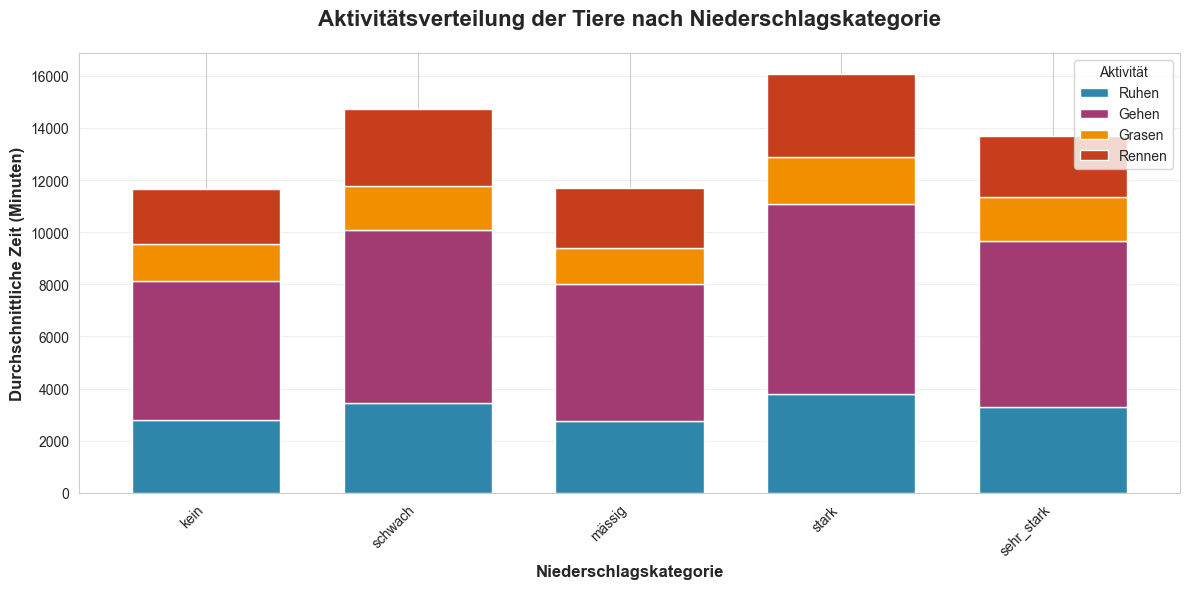


=== Durchschnittliche Aktivitätsdauer nach Regenkategorie (Minuten) ===
               state_resting  state_walking  state_grazing  state_running
rain_category                                                            
kein                 2798.77        5339.45        1395.89        2115.90
schwach              3431.82        6660.39        1671.84        2954.28
mässig               2739.39        5267.18        1387.33        2285.61
stark                3785.23        7293.35        1807.60        3186.47
sehr_stark           3295.70        6368.75        1676.15        2347.34


In [16]:
# 1. Aktivitätsverteilung nach Niederschlagskategorie
# Daten aggregieren: Durchschnittliche Minuten pro Aktivität nach Regenkategorie

activity_cols = ['state_resting', 'state_walking', 'state_grazing', 'state_running']

# Gruppieren nach Regenkategorie und Mittelwerte berechnen
activity_by_rain = df_viz.groupby('rain_category')[activity_cols].mean()

# Regenkategorien sortieren (von kein bis sehr_stark)
rain_order = ['kein', 'sehr_schwach', 'schwach', 'mässig', 'stark', 'sehr_stark']
activity_by_rain = activity_by_rain.reindex([cat for cat in rain_order if cat in activity_by_rain.index])

# Stacked Bar Chart
fig, ax = plt.subplots(figsize=(12, 6))

# Farben für die Aktivitäten
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

activity_by_rain.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    width=0.7
)

ax.set_title('Aktivitätsverteilung der Tiere nach Niederschlagskategorie',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Niederschlagskategorie', fontsize=12, fontweight='bold')
ax.set_ylabel('Durchschnittliche Zeit (Minuten)', fontsize=12, fontweight='bold')
ax.legend(['Ruhen', 'Gehen', 'Grasen', 'Rennen'],
          title='Aktivität', loc='upper right', frameon=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Grid anpassen
ax.grid(axis='y', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('data/processed/aktivitaetsverteilung.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistik ausgeben
print("\n=== Durchschnittliche Aktivitätsdauer nach Regenkategorie (Minuten) ===")
print(activity_by_rain.round(2))


### 2. Zeitreihen-Analyse: Niederschlag und Aktivität über Zeit

Diese Dual-Axis-Visualisierung zeigt den zeitlichen Verlauf von Niederschlag und Tieraktivität.
Die blaue Linie zeigt die Niederschlagsmenge (mm/h), während die farbigen Bereiche die
durchschnittliche Aktivitätsdauer darstellen.


C:\Users\thier\AppData\Local\Temp\ipykernel_13016\1078918002.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_viz['hour'] = pd.to_datetime(df_viz['spokes_ts']).dt.floor('H')


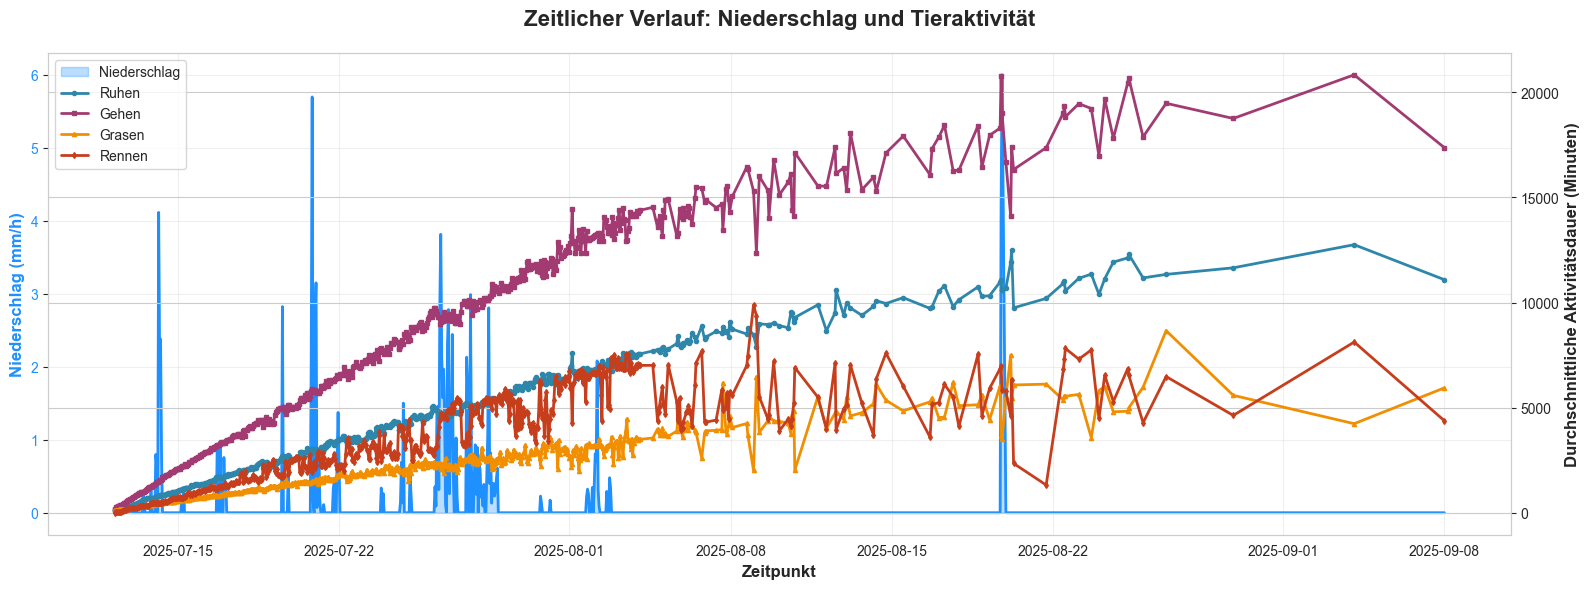


=== Korrelation: Niederschlag ↔ Aktivität ===
state_resting    0.023
state_walking    0.025
state_grazing    0.013
state_running    0.033
Name: rain_h, dtype: float64


In [17]:
# 2. Zeitreihen-Analyse: Niederschlag und Aktivität über Zeit

# Daten nach Stunden aggregieren für bessere Übersichtlichkeit
df_viz['hour'] = pd.to_datetime(df_viz['spokes_ts']).dt.floor('H')

# Gruppieren nach Stunde
hourly_data = df_viz.groupby('hour').agg({
    'rain_h': 'mean',
    'state_resting': 'mean',
    'state_walking': 'mean',
    'state_grazing': 'mean',
    'state_running': 'mean'
}).reset_index()

# Dual-Axis Plot
fig, ax1 = plt.subplots(figsize=(16, 6))

# Niederschlag (linke Y-Achse)
color_rain = '#1E90FF'
ax1.set_xlabel('Zeitpunkt', fontsize=12, fontweight='bold')
ax1.set_ylabel('Niederschlag (mm/h)', fontsize=12, fontweight='bold', color=color_rain)
ax1.fill_between(hourly_data['hour'], hourly_data['rain_h'],
                 alpha=0.3, color=color_rain, label='Niederschlag')
ax1.plot(hourly_data['hour'], hourly_data['rain_h'],
         color=color_rain, linewidth=2, label='_nolegend_')
ax1.tick_params(axis='y', labelcolor=color_rain)
ax1.grid(True, alpha=0.3)

# Aktivitäten (rechte Y-Achse)
ax2 = ax1.twinx()
ax2.set_ylabel('Durchschnittliche Aktivitätsdauer (Minuten)',
               fontsize=12, fontweight='bold')

# Aktivitätslinien plotten
ax2.plot(hourly_data['hour'], hourly_data['state_resting'],
         color='#2E86AB', linewidth=2, label='Ruhen', marker='o', markersize=3)
ax2.plot(hourly_data['hour'], hourly_data['state_walking'],
         color='#A23B72', linewidth=2, label='Gehen', marker='s', markersize=3)
ax2.plot(hourly_data['hour'], hourly_data['state_grazing'],
         color='#F18F01', linewidth=2, label='Grasen', marker='^', markersize=3)
ax2.plot(hourly_data['hour'], hourly_data['state_running'],
         color='#C73E1D', linewidth=2, label='Rennen', marker='d', markersize=3)

# Titel und Legende
plt.title('Zeitlicher Verlauf: Niederschlag und Tieraktivität',
          fontsize=16, fontweight='bold', pad=20)

# Legenden kombinieren
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2,
           loc='upper left', frameon=True, fontsize=10)

# X-Achse formatieren
plt.xticks(rotation=45, ha='right')
fig.tight_layout()

plt.savefig('data/processed/zeitliche_muster.png', dpi=300, bbox_inches='tight')
plt.show()

# Korrelationsanalyse
print("\n=== Korrelation: Niederschlag ↔ Aktivität ===")
corr_data = df_viz[['rain_h', 'state_resting', 'state_walking', 'state_grazing', 'state_running']].corr()
print(corr_data['rain_h'].drop('rain_h').round(3))


### Interpretation der Ergebnisse

**Aktivitätsverteilung nach Niederschlag:**
- Die gestapelte Balkenvisualisierung zeigt deutlich, wie sich die Verhaltensweisen bei unterschiedlichen Niederschlagsintensitäten verändern
- Wichtige Frage: Ruhen Tiere mehr bei starkem Regen? Grasen sie weniger?

**Zeitliche Muster:**
- Die Dual-Axis-Darstellung ermöglicht den direkten visuellen Vergleich zwischen Wetterereignissen und Verhaltensänderungen
- Zeitliche Verzögerungen zwischen Niederschlag und Verhaltensänderungen können erkannt werden

**Korrelationswerte:**
- Positive Werte: Aktivität steigt mit Niederschlag
- Negative Werte: Aktivität sinkt mit Niederschlag
- Werte nahe 0: Kein linearer Zusammenhang


In [18]:
time_anlysies = time.time() - start_analyzis
print(f"Datenanalyse-Verarbeitung: {time_anlysies:.2f} Sekunden")

Datenanalyse-Verarbeitung: 12.31 Sekunden


# 4. Performance-Messungen

In [19]:
print("\n+------------------------------+-----------+")
print("| Schritt                      | Zeit (s)  |")
print("+------------------------------+-----------+")
print(f"| Daten-Verarbeitung           | {time_dataload:9.2f} |")
print(f"| Join-Verarbeitung            | {time_joins:9.2f} |")
print(f"| Datenanalyse-Verarbeitung    | {time_anlysies:9.2f} |")
print("+------------------------------+-----------+")
print(f"| Job-Verarbeitung (Total)     | {time.time() - start_job:9.2f} |")
print("+------------------------------+-----------+\n")



+------------------------------+-----------+
| Schritt                      | Zeit (s)  |
+------------------------------+-----------+
| Daten-Verarbeitung           |      6.00 |
| Join-Verarbeitung            |      7.55 |
| Datenanalyse-Verarbeitung    |     12.31 |
+------------------------------+-----------+
| Job-Verarbeitung (Total)     |     31.79 |
+------------------------------+-----------+

